# Лабораторная работа №4: Optuna

## Постановка задачи

1. Найти оптимумы тестовых функций средствами Optuna

2. Осуществить подбор параметров модели классификации с помощью Optuna

3. Визуализировать полученный результат

## Источники

* [Документация по Optuna](https://optuna.readthedocs.io/en/stable/index.html)
* [Логистическая регрессия](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)


# Подключение зависимостей

In [117]:
import sys
import math
import optuna
import sklearn
import plotly
import numpy as np

from matplotlib import pyplot as plt

# Вспомогательные функции

In [3]:
def draw_search_result(prob, found_params: np.ndarray, resolution: int = 1000):

  """ Визузуализация проблемы

  Args:
      prob (_type_): Проблема
      resolution (int, optional): Разрешение сетки. Defaults to 1000.
  """

  bounds = np.array(prob.get_bounds())
  fitness = prob.fitness
  glob_min = prob.get_glob_min()

  x = np.linspace(bounds[0, 0], bounds[1, 0], resolution)
  y = np.linspace(bounds[0, 1], bounds[1, 1], resolution)

  x_grid, y_grid = np.meshgrid(x, y)
  z_grid = fitness([x_grid, y_grid])

  fig = plt.figure(figsize = (10, 8))
  ax = plt.axes()

  ax.set_title(prob.__name__)
  ax.legend(loc="upper left")
  ax.set_xlabel('x')
  ax.set_ylabel('y')

  plt.contour(x_grid, y_grid, z_grid, 20);
  ax.contour(x_grid, y_grid, z_grid, 20);
  ax.scatter(glob_min[0], glob_min[1], s=100, c="red", lw=2, ec='black', marker = 'o', label="Глобальный минимум")
  ax.scatter(found_params[0], found_params[1], s=150, c="white", lw=2, ec='black', marker = 'X', label="Найденный минимум")
  plt.colorbar()
  ax.legend()

  x_error = abs(found_params[0] - prob.get_glob_min()[0]) 
  y_error = abs(found_params[1] - prob.get_glob_min()[1]) 
  z_error = abs(prob.fitness(found_params) - prob.get_glob_min()[2]) 
  print(f'Погрешность: {x_error, y_error, z_error}')

# 1. Поиск оптимума функции средствами Optuna

## Определение тестовых функций

### Функция Сферы
* Функция: $f(\boldsymbol{x}) = \sum_{i=1}^{n} x_{i}^{2}$
* Область определения: $ -\infty \le x_{i} \le \infty$
* Глобальный минимум: $f(x_{1}, \dots, x_{n}) = f(0, \dots, 0) = 0$

In [4]:
class Sphere:

    @staticmethod
    def fitness(x: np.ndarray):
        return x[0]*x[0] + x[1]*x[1]

    @staticmethod
    def get_bounds():
        return np.array([[-10., -10.], [10., 10.]])

    @staticmethod
    def get_glob_min():
        return np.array([0., 0., 0.])
    
    @staticmethod
    def get_default_start_point():
        return np.array([2.0, 2.7])

### Функция Мак Кормика
* Функция: $f(x,y) = \sin \left(x+y\right) + \left(x-y\right)^{2} - 1.5x + 2.5y + 1$
* Область определения: $-1.5\le x \le 4 \:and\: -3\le y \le 4$
* Глобальный минимум: $f(-0.54719,-1.54719) = -1.9133$

In [5]:
class McCormick:

    @staticmethod
    def fitness(x: np.ndarray):
        return np.sin(x[0] + x[1]) + (x[0] - x[1]) ** 2 - 1.5 * x[0] + 2.5 * x[1] + 1

    @staticmethod
    def get_bounds():
        return np.array([[-1.5, -3.], [5., 4.]])

    @staticmethod
    def get_glob_min():
        return np.array([-0.54719, -1.54719, -1.9133])

    @staticmethod
    def get_default_start_point():
        return np.array([-1.0, 3.0])

## Поиск оптимумов функции сферы

In [136]:

def objective_Sphere(trial):
  x = np.array([0, 0])
  x[0] = trial.suggest_float("x[0]", Sphere.get_bounds()[0,0], Sphere.get_bounds()[1,0])
  x[1] = trial.suggest_float("x[1]", Sphere.get_bounds()[0,1], Sphere.get_bounds()[1,1])
  return Sphere.fitness(x)

optuna.logging.set_verbosity(optuna.logging.ERROR)
study = optuna.create_study()
study.optimize(objective_Sphere, n_trials = 200)
found_params = [study.best_params["x[0]"], study.best_params["x[1]"]]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Погрешность: (0.4434509407779519, 0.30916481928882256, 0.2922316223627409)


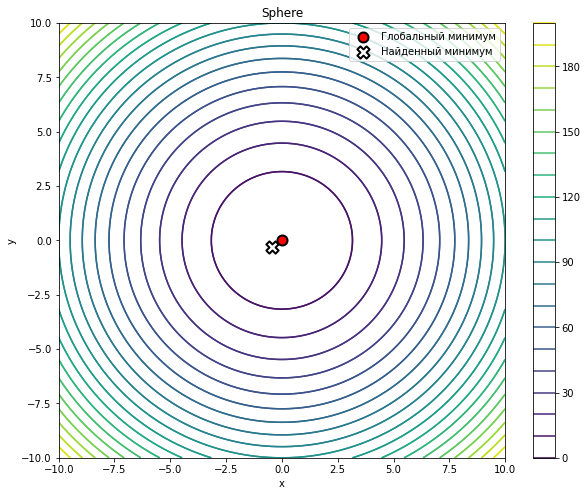

In [137]:
draw_search_result(Sphere, found_params)

## Поиск оптимумов функции Мак Кормика

In [138]:
def objective_McCormick(trial):
  x = np.array([0, 0])
  x[0] = trial.suggest_float("x[0]", McCormick.get_bounds()[0,0], McCormick.get_bounds()[1,0])
  x[1] = trial.suggest_float("x[1]", McCormick.get_bounds()[0,1], McCormick.get_bounds()[1,1])
  return McCormick.fitness(x)

study = optuna.create_study()
study.optimize(objective_McCormick, n_trials = 200)
found_params = [study.best_params["x[0]"], study.best_params["x[1]"]]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Погрешность: (0.6334710568970615, 1.2045952557477757, 0.984213551632942)


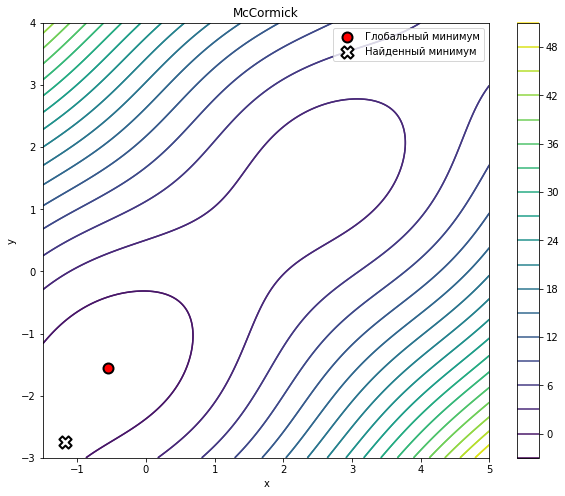

In [139]:
draw_search_result(McCormick, found_params)

# 2. Решение задачи классификации ирисов c помощью подбора параметров логистической регрессии средствами Optuna



## Загрузка датасета

In [149]:
X, y = sklearn.datasets.load_iris(return_X_y=True)
train_x, valid_x, train_y, valid_y = sklearn.model_selection.train_test_split(X, y)

## Определение оптимизируемой функции

In [150]:
def objective(trial):
  C = trial.suggest_float("C", 1e-5, 1, log=True)
  tol = trial.suggest_float("tol", 1e-1, 10, log=True)
  solver = trial.suggest_categorical("solver", ["newton-cg", "lbfgs", "liblinear", "sag", "saga"])
  clf = sklearn.linear_model.LogisticRegression(C=C, tol=tol, solver=solver)
  
  for step in range(100):
    clf.fit(train_x, train_y)
    intermediate_value = clf.score(valid_x, valid_y)
    trial.report(intermediate_value, step=step)
    
    if trial.should_prune():
      raise optuna.TrialPruned()
      
    return clf.score(valid_x, valid_y)

## Оптимизация

In [151]:
study = optuna.create_study(pruner=optuna.pruners.MedianPruner(n_warmup_steps=10))
study.optimize(objective, n_trials=30)

## Результаты оптимизации

### История оптимизации
<img src="media/plot_optimization_history.png">

In [152]:
#optuna.visualization.plot_optimization_history(study)

### Взаимосвязи гиперпараметров
<img src="media/plot_parallel_coordinate.png">
<img src="media/plot_contour.png">

In [153]:
# optuna.visualization.plot_parallel_coordinate(study)

In [154]:
# optuna.visualization.plot_contour(study)

### Влияние признаков
<img src="media/plot_param_importances.png">

In [155]:
# optuna.visualization.plot_param_importances(study)

### Зависимость гиперпараметров от исходных значений
<img src="media/plot_slice.png">

In [156]:
# optuna.visualization.plot_slice(study)

### Эмпирическая функция распределения
<img src="media/plot_edf.png">

In [157]:
# optuna.visualization.plot_edf(study)